# Agent interaction analysis
## Step by step data extraction

In [2]:
# Imports
import pandas as pd
# from egg.core.interaction import Interaction
import torch
from sklearn.decomposition import PCA
from pathlib import Path
from matplotlib import pyplot as plt
# used in a later part of the script :
# import seaborn as sns
# import numpy as np


In [3]:
# Path to your interaction file
import os
path_to_interaction = Path("/Users/u203445/Documents/projects/EGG/")
inter = torch.load(path_to_interaction / "cont_interactions_2")


In [4]:
cont_messages = torch.cat([a for a in inter.message])
print("mean = ",cont_messages.mean().item())
print("standard deviation = ",cont_messages.std().item())


mean =  0.4151911735534668
standard deviation =  0.2668488621711731


In [5]:
def interaction_to_dataframe(interaction):
    """
    Function to turn the Interaction file into a pandas DataFrame which is covered with syntaxic sugar so easy to use
    """
    df = pd.DataFrame()
    # skipped as is empty in the emecom_pop case
    # df["sender_input"] = interaction.sender_input
    # df["receiver_input"] = interaction.receiver_input
    df["labels"] = interaction.labels
    for key in interaction.aux_input:
        if key == "receiver_message_embedding": # in continuous format message and receiver embedding are the same
            for dim, value in enumerate(interaction.message.T):
                df[f"dim_{dim}"] = value
        else:
            df[key] = interaction.aux_input[key]
    df["receiver_output"] = [i.argmax().item() for i in interaction.receiver_output]

    return df

In [6]:
df_inter = interaction_to_dataframe(inter)
# quick overview of what the dataframe looks like
# the function .sample(10) randomly selects 10 elements from the DataFrame
print(df_inter.sample(3))

       labels  sender_idx  recv_idx  loss_idx  batch_number     dim_0  \
8875       45           0         1         0          3883  0.404930   
16724      12           0         3         0          1748  0.537352   
5661       28           0         1         0           669  0.097923   

          dim_1     dim_2     dim_3     dim_4  ...     dim_7     dim_8  \
8875   0.392814  0.100808  0.226216  0.629903  ...  0.511309  0.926926   
16724  0.365622  0.117543  0.244147  0.068853  ...  0.140513  0.781646   
5661   0.339585  0.125366  0.317592  0.313841  ...  0.377581  0.124845   

          dim_9    dim_10    dim_11    dim_12    dim_13    dim_14    dim_15  \
8875   0.440567  0.244809  0.904192  0.197958  0.098268  0.251969  0.405542   
16724  0.437831  0.232673  0.934862  0.262594  0.699093  0.446488  0.626249   
5661   0.555411  0.214529  0.658970  0.640764  0.788885  0.738487  0.725779   

       receiver_output  
8875                43  
16724               20  
5661              

## Begining of a PCA analysis
lets make a 2 component PCA with the scikit-learn tool, to get a visual idea of clusters and their correspondance to the pretrained 'human' classes

In [20]:
# select which sender to analyse and which pretraining class labels
# chosen_sender_index = [0,1,2,3]
_chosen_sender_index = [2,3]
# _chosen_labels = [i for i in range(100)]
_chosen_labels = [1, 32, 80]
# taking only the interactions that have the matching indexes for the sender and the class labels
selectedsender_interactions = df_inter[df_inter.sender_idx.isin(_chosen_sender_index)]
selectedsender_interactions = df_inter[df_inter.labels.isin(_chosen_labels)]

In [21]:
# Doing the actual PCA
n_components=10
pca = PCA(n_components)
x = selectedsender_interactions.loc[:, selectedsender_interactions.columns.str.contains('dim')]
principalComponents = pca.fit_transform(x)
df_pca = pd.DataFrame(data = principalComponents
             , columns = [f'principal component {i+1}' for i in range(n_components)])

# adding the labels for colouring purposes in plot
df_pca['labels'] = selectedsender_interactions.labels.values
print(df_pca.sample(3))

      principal component 1  principal component 2  principal component 3  \
13                 0.635245              -0.068668               0.127172   
1475               0.216999               0.511254              -0.174616   
2460              -0.212777               0.385037              -0.176111   

      principal component 4  principal component 5  principal component 6  \
13                 0.215569              -0.261842              -0.121826   
1475               0.225065               0.010517               0.102149   
2460              -0.345027              -0.187786               0.351753   

      principal component 7  principal component 8  principal component 9  \
13                 0.236972               0.010601              -0.220941   
1475               0.583379              -0.308174               0.087490   
2460              -0.417660              -0.054537               0.570311   

      principal component 10  labels  
13                 -0.556610      

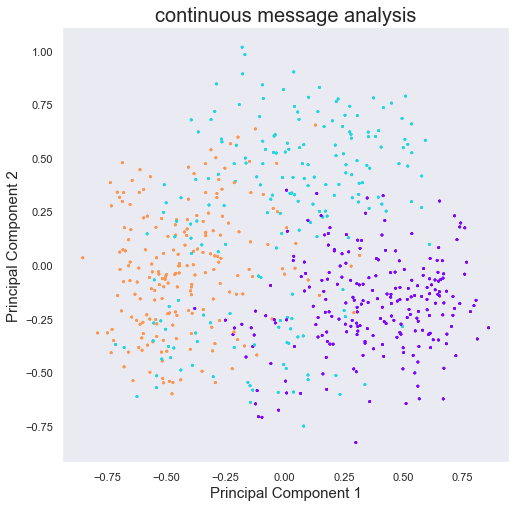

In [22]:
# plotting the PCA (looking at all the data is too complex)
# Chose here which components you want to look at (1 and 2 should have most information) 
prin_comp_A = 1
prin_comp_B = 2

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel(f'Principal Component {prin_comp_A}', fontsize = 15)
ax.set_ylabel(f'Principal Component {prin_comp_B}', fontsize = 15)
ax.set_title('continuous message analysis', fontsize = 20)
colors = plt.cm.rainbow(torch.arange(0, 1, 0.01))

# here I´m colouring the different classes with different colours
ax.scatter(df_pca[f'principal component {prin_comp_A}']
            , df_pca[f'principal component {prin_comp_B}']
            , color = colors[df_pca['labels']]
            , s = 3)
ax.grid()

## Some other basic things
Looking at the message distribution for intuition of where the information is hidden

In [10]:
import seaborn as sns

In [11]:
melted_df = df_inter.melt(["sender_idx","loss_idx", "recv_idx", "labels", "receiver_output", "batch_number"], var_name="dim", value_name="message_value")
print(melted_df.sample(3))

        sender_idx  loss_idx  recv_idx  labels  receiver_output  batch_number  \
596310           1         0         3      65               22          2262   
73360            3         0         2      20               21          3472   
969901           0         0         2      46               45          1453   

           dim  message_value  
596310   dim_7       0.226289  
73360    dim_0       0.126457  
969901  dim_12       0.737502  


<AxesSubplot:xlabel='dim', ylabel='message_value'>

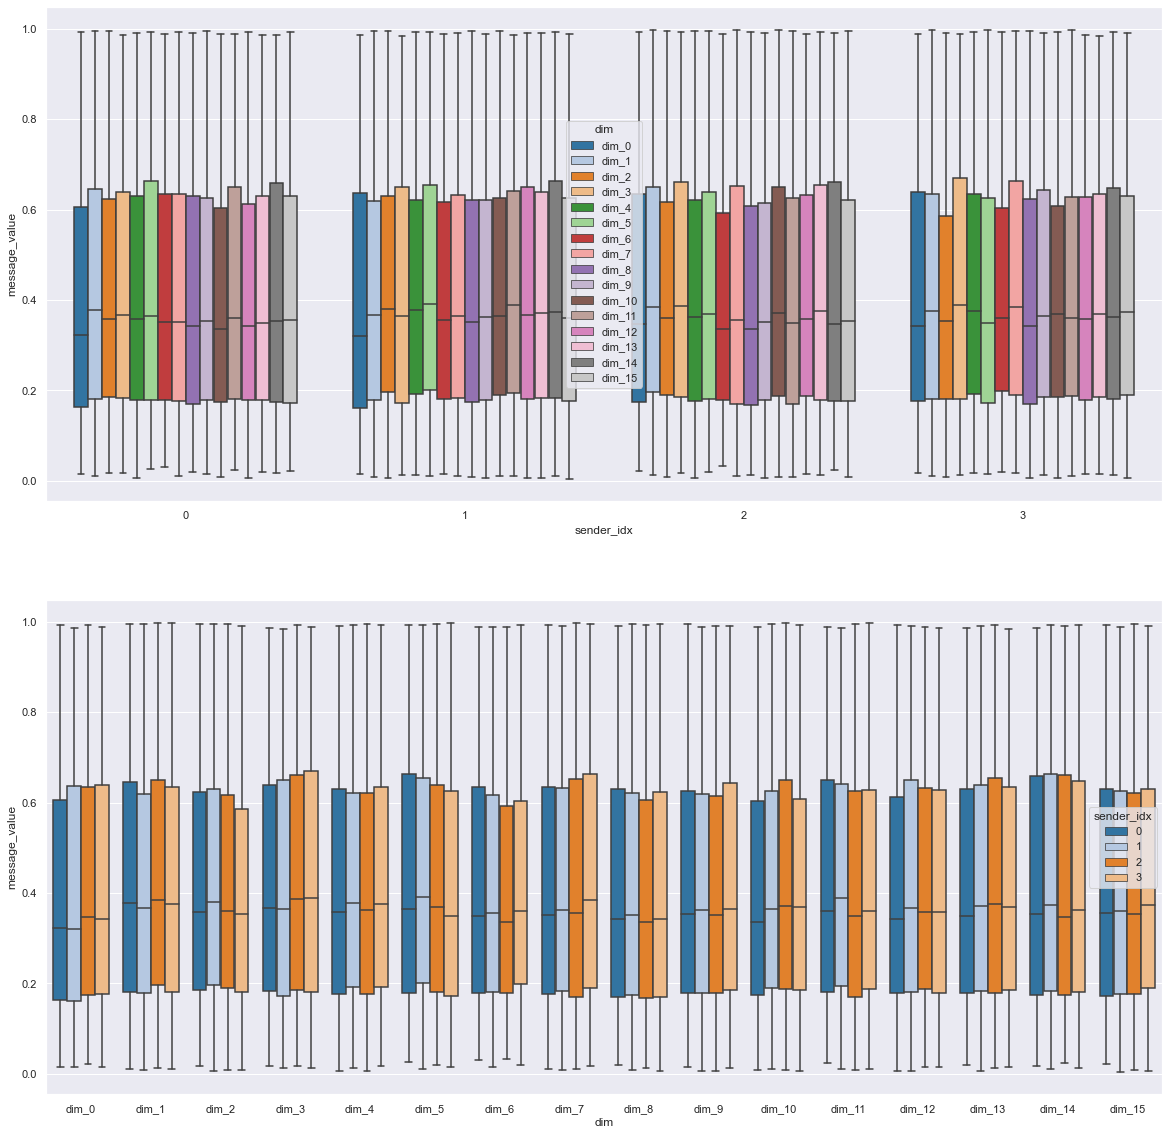

In [23]:
#lets check messages are evenly distributed accross dimensions and senders
sns.set(rc={'figure.figsize':(20,20)})
fig, axes = plt.subplots(2,1) 
sns.boxplot(x=melted_df.sender_idx, y=melted_df.message_value, hue=melted_df.dim, palette=sns.color_palette("tab20",16),ax=axes[0])
sns.boxplot(x=melted_df.dim, y=melted_df.message_value, hue=melted_df.sender_idx, palette=sns.color_palette("tab20",16),ax=axes[1])

# This does not seem to call for further statistical testing... quite similar, they've all gone through a sigmoid. Might still check to be sure.

In [13]:
# change the index of the sender to analyse here :
sender_idx = 3

<AxesSubplot:xlabel='dim', ylabel='message_value'>

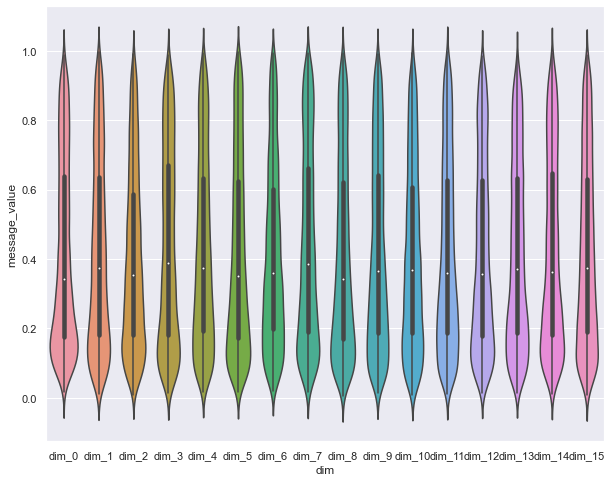

In [14]:
sns.set(rc={'figure.figsize':(10,8)})
sns.violinplot(x=melted_df[melted_df.sender_idx == sender_idx].dim, y=melted_df[melted_df.sender_idx == sender_idx].message_value)
# This tends to give an idea of what the saturation point is for the sigmoid... I'd set it around 0.35

C:\Users\u203445\AppData\Local\Temp\ipykernel_22744\114716662.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  _df = melted_df[melted_df.sender_idx == sender_idx][melted_df.labels==label]
C:\Users\u203445\AppData\Local\Temp\ipykernel_22744\114716662.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  _df = melted_df[melted_df.sender_idx == sender_idx][melted_df.labels==label]
C:\Users\u203445\AppData\Local\Temp\ipykernel_22744\114716662.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  _df = melted_df[melted_df.sender_idx == sender_idx][melted_df.labels==label]
C:\Users\u203445\AppData\Local\Temp\ipykernel_22744\114716662.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  _df = melted_df[melted_df.sender_idx == sender_idx][melted_df.labels==label]
C:\Users\u203445\AppData\Local\Temp\ipykernel_22744\114716662.py:4: UserWarning: Boolean Series key will be 

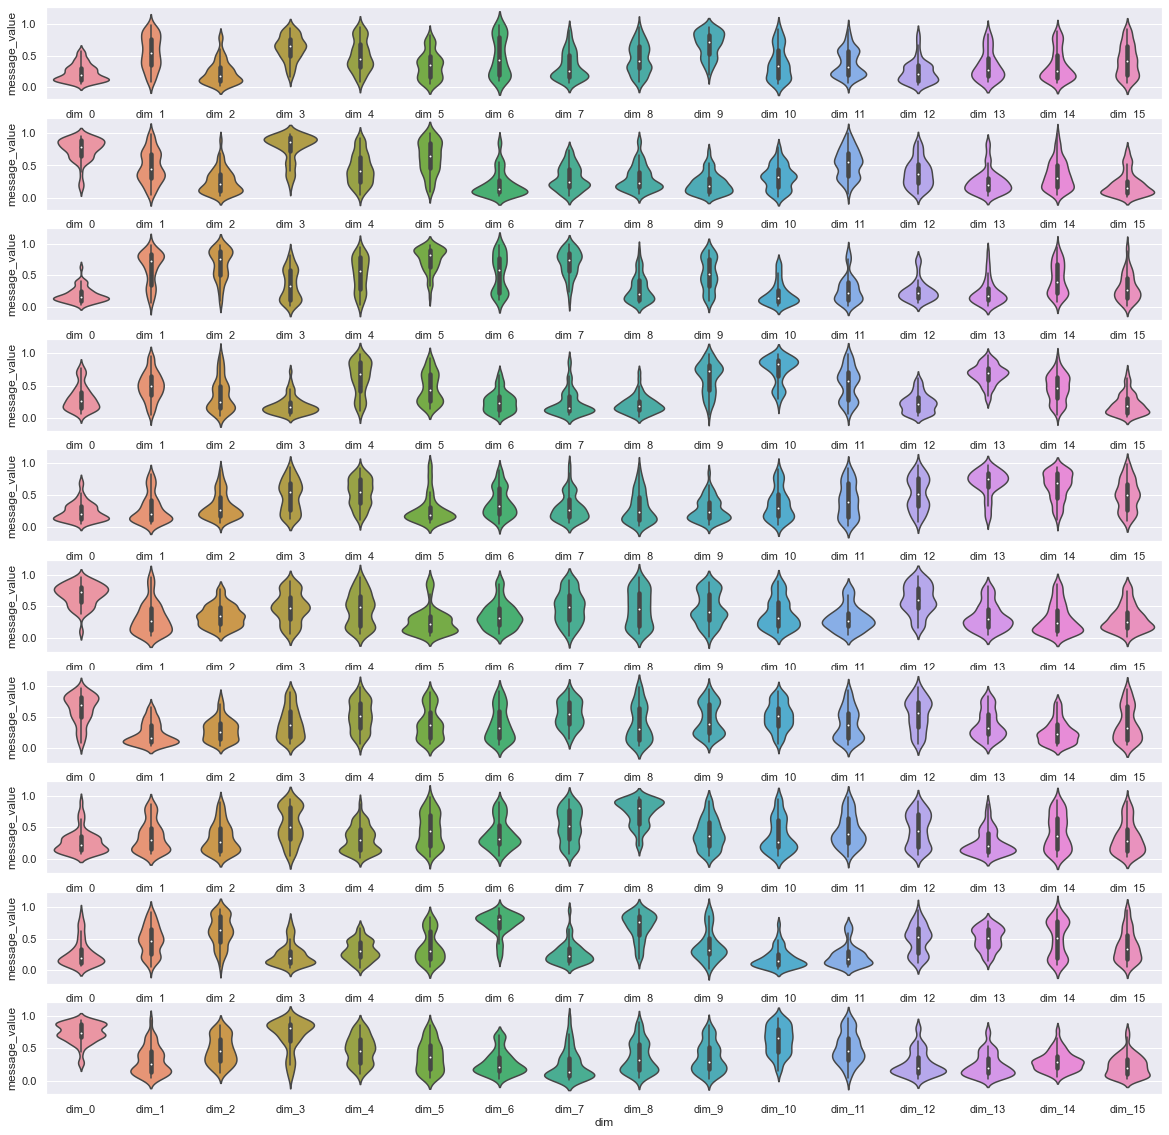

In [15]:
sns.set(rc={'figure.figsize':(20,20)})
fig, axes = plt.subplots(10,1) 
for i, label in enumerate(melted_df.labels.sample(10)):
    _df = melted_df[melted_df.sender_idx == sender_idx][melted_df.labels==label]
    if len(_df) != 0:
        sns.violinplot(x=_df.dim, y=_df.message_value, ax=axes[i])

# We can see variations in dimensional distribution depending on the pre-training classes 
# (which can be understood as either an approximation of the actual clustering, or perhaps the beginning of an analysis of model capacities in out-of-scope contexts)

<AxesSubplot:>

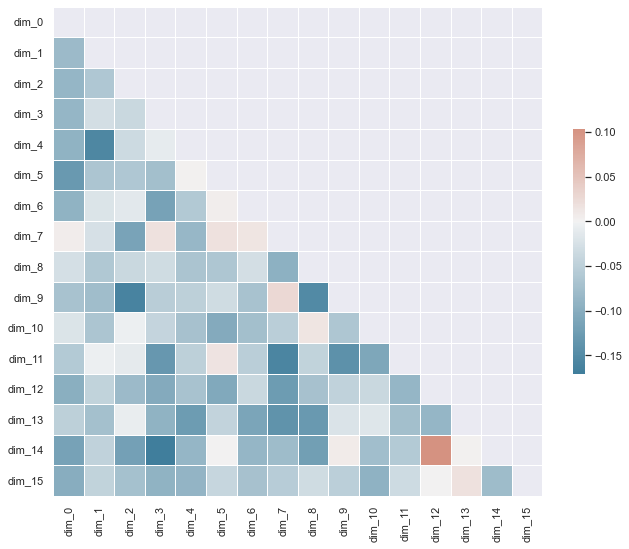

In [33]:
# Ok. Correlation between dimensions now
import numpy as np
# Compute the correlation matrix
# (just on the dims, not on the rest of the information in interactions)
corr = df_inter.loc[:,df_inter.columns.str.contains('dim')].corr()
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

# looks quite independant no ?